# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [197]:
#Import all the required libraries
import pandas as pd
import os
import time
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import numpy as np
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras import Model


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [82]:
#Import the dataset and read the image into a seperate variable

# cwd = os.getcwd()

images='/kaggle/input/flickr8k/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [83]:
def plot_images(images, captions,n_rows=4, n_plots=4):
    plt.figure(figsize=(20,20))
    for i in range(len(images)):
        plt.subplot(n_rows,n_plots,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mpimg.imread(images[i]))
        plt.xlabel(captions[i])

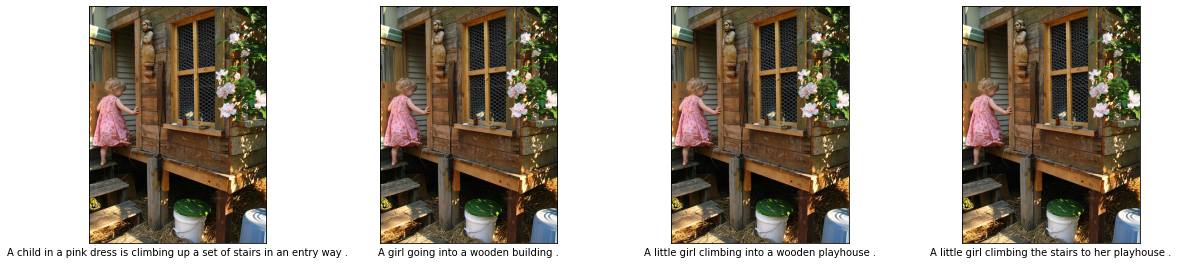

In [84]:
#Visualise both the images & text present in the dataset
with open('/kaggle/input/flickr8k/captions.txt') as f:
    captions = f.read()

captions = captions.split('\n')

images_for_plots = [images+'/'+captions[i].split(',')[0] for i in range(1, 5)]
captions_for_plots = [captions[i].split(',')[1] for i in range(1, 5)]

plot_images(images_for_plots, captions_for_plots)

In [85]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    with open(filename) as f:
        text = f.read()
    
    text = text.split('\n')
    
    return text

text_file='/kaggle/input/flickr8k/captions.txt'
doc = load_doc(text_file)
print(doc[:300])

['image,caption', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .', '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hand

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [86]:
all_img_id= [doc[i].split(',')[0].split('.')[0] for i in range(1, len(doc)-1)]
all_img_vector= [images+'/'+doc[i].split(',')[0] for i in range(1, len(doc)-1)]
annotations= [doc[i].split(',')[1] for i in range(1, len(doc)-1)]

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e,/kaggle/input/flickr8k/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,/kaggle/input/flickr8k/Images/1000268201_693b0...,A girl going into a wooden building .
2,1000268201_693b08cb0e,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl in a pink dress going into a woo...


In [87]:
#Create the vocabulary & the counter for the captions

vocabulary= []
for caption in df.Captions:
    vocabulary.extend(caption.split(' '))


val_count=Counter(vocabulary)

In [88]:
#Visualise the top 30 occuring words in the captions

#write your code here
val_count.most_common(30)

[('a', 38716),
 ('.', 34205),
 ('A', 21480),
 ('in', 18170),
 ('the', 14587),
 ('on', 10354),
 ('is', 9069),
 ('and', 8057),
 ('dog', 7804),
 ('with', 7303),
 ('man', 6727),
 ('of', 6495),
 ('Two', 3962),
 ('white', 3646),
 ('black', 3491),
 ('boy', 3395),
 ('are', 3364),
 ('girl', 3174),
 ('woman', 3146),
 ('to', 3005),
 ('The', 2919),
 ('wearing', 2916),
 ('at', 2809),
 ('water', 2671),
 ('red', 2542),
 ('', 2447),
 ('young', 2411),
 ('people', 2397),
 ('brown', 2383),
 ('his', 2255)]

In [89]:
#Create a list which contains all the captions
annotations=list(df.Captions)

#add the <start> & <end> token to all those captions as well
annotations =['<start> ' + annotation + ' <end>' for annotation in annotations]

#Create a list which contains all the path to the images
all_img_path=list(df.Path)

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [90]:
# create the tokenizer

top_words = 5000

#your code here
tokenizer = Tokenizer(num_words=top_words, oov_token='UNK', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)

In [91]:
# Create word-to-index and index-to-word mappings.

#your code here
word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word

In [92]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
post_process_val_count = Counter(word_to_index)
post_process_val_count.most_common(30)

[('patterns', 8323),
 ('scrolled', 8322),
 ('majestically', 8321),
 ('weight', 8320),
 ('spaniels', 8319),
 ('cocker', 8318),
 ('breezeway', 8317),
 ('rainstorm', 8316),
 ('containig', 8315),
 ('swatting', 8314),
 ('calico', 8313),
 ('keffiyahs', 8312),
 ('started', 8311),
 ('since', 8310),
 ('ever', 8309),
 ('bodysurfs', 8308),
 ('consumer', 8307),
 ('sunlit', 8306),
 ('rickety', 8305),
 ('driftrood', 8304),
 ('slat', 8303),
 ('shaky', 8302),
 ('nest', 8301),
 ('snowpacked', 8300),
 ('encripted', 8299),
 ('creamy', 8298),
 ('cresting', 8297),
 ('waterline', 8296),
 ('brwon', 8295),
 ('withdrawing', 8294)]

In [93]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

# Text to sequences
captions_sequences = tokenizer.texts_to_sequences(annotations)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(captions_sequences, padding='post')

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 35)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [94]:
#write your code here
"""
We will create a function that will be used in the Tensorflow dataset APIs.
This will load the images lazly on the fly and transform them.

This is done in order to avoid the excesive use of RAM during transformation
""" 

def resize_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299,299))

    return tf.keras.applications.inception_v3.preprocess_input(img), image_path

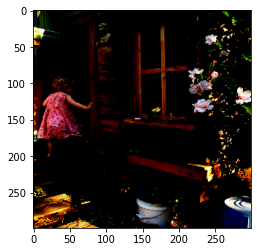

In [95]:
img, _ = resize_image(all_img_path[0])
plt.imshow(img)

In [96]:
#write your code here
BATCH_SIZE = 64

encoded_set = sorted(set(all_img_vector))

feature_dict = {}

image_dataset = tf.data.Dataset.from_tensor_slices(encoded_set)
image_dataset = image_dataset.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [97]:

# Splitting data into Train and Test with the ratio of 80-20
X_train, X_test, y_train, y_test = train_test_split(all_img_vector, cap_vector, test_size=0.2, random_state=42)

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_dataset = dataset.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# test_dataset = dataset.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [98]:
len(X_train), len(y_test)

(32364, 8091)

In [99]:
def map_features(image_name, caption):
    img_tensor = feature_dict[image_name.decode('utf-8')]
    return img_tensor, caption

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [100]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [101]:
image_features_extract_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, None, None, 3 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, None, None, 3 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [102]:
# write your code to extract features from each image in the dataset

for img, path in tqdm(image_dataset):
    img_features = image_features_extract_model(img)
    img_features = tf.reshape(img_features, [img_features.shape[0], -1, img_features.shape[3]])
    for batch_f, p in zip(img_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 127/127 [00:34<00:00,  3.69it/s]


In [103]:
# Generationg train and test Dataset
BUFFER_SIZE = 1000

def build_dataset(image_paths, captions):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, captions))
    dataset = dataset.shuffle(BUFFER_SIZE)
    
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_features, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)
    
    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [104]:
train_dataset = build_dataset(X_train, y_train)
test_dataset = build_dataset(X_test, y_test)

In [105]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [106]:
embedding_dim = 256 
units = 512
vocab_size = top_words+1
train_num_steps = len(X_train) // BATCH_SIZE
test_num_steps = len(X_test) // BATCH_SIZE

train_num_steps, test_num_steps

(505, 126)

### Encoder

In [107]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = Dense(embed_dim, activation='relu')
        
    def call(self, features):
        features =  self.dense(features)
        
        return features

In [108]:
encoder=Encoder(embedding_dim)

### Attention model

In [109]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = Dense(units)#build your Dense layer
        self.W2 = Dense(units)#build your Dense layer
        self.V = Dense(1)#build your final Dense layer with unit 1

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        
        score = self.V(attention_hidden_layer)# build your score funciton to shape: (batch_size, 8*8, units)
        
        attention_weights =  tf.nn.softmax(score, axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        
        context_vector =  attention_weights * features#shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        
        return context_vector, attention_weights

### Decoder

In [124]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(units)#iniitalise your Attention model with units
        self.embed = Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = Dense(units)#build your Dense layer
        self.d2 = Dense(vocab_size)#build your Dense layer
        self.dropout = Dropout(0.5)
        

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        
        embed = self.dropout(self.embed(x)) # embed your input to shape: (batch_size, 1, embedding_dim)
        
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        
        output = self.d1(output)
        
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [125]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [126]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [127]:
optimizer = tf.keras.optimizers.Adam()#define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')#define your loss object

In [128]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [129]:
checkpoint_path = os.getcwd()+"/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [130]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [140]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            preds, hidden_state, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], preds)
            
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = loss / int(target.shape[1])
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [141]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #write your code here to do the testing steps
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            preds, hidden_state, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], preds)
            
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = loss / int(target.shape[1])
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss, avg_loss

In [142]:
def test_loss_cal(test_dataset):
    total_loss = 0
    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    
    avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [143]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [147]:
loss_plot = []
test_loss_plot = []
EPOCHS = 20

with tf.device('/gpu:0'):
    best_test_loss=100
    for epoch in tqdm(range(0, EPOCHS)):
        start = time.time()
        total_loss = 0
        for (batch, (img_tensor, target)) in enumerate(train_dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss
            avg_train_loss=total_loss / train_num_steps

        loss_plot.append(avg_train_loss)    
        test_loss = test_loss_cal(test_dataset)
        test_loss_plot.append(test_loss)

        print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

        if test_loss < best_test_loss:
            print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
            best_test_loss = test_loss
            ckpt_manager.save()

  5%|▌         | 1/20 [01:11<22:36, 71.40s/it]

For epoch: 1, the train loss is 0.516, & test loss is 0.504
Time taken for 1 epoch 71.27062582969666 sec

Test loss has been reduced from 100.000 to 0.504


 10%|█         | 2/20 [02:22<21:24, 71.37s/it]

For epoch: 2, the train loss is 0.500, & test loss is 0.489
Time taken for 1 epoch 71.21714282035828 sec

Test loss has been reduced from 0.504 to 0.489


 15%|█▌        | 3/20 [03:34<20:14, 71.42s/it]

For epoch: 3, the train loss is 0.487, & test loss is 0.475
Time taken for 1 epoch 71.28464388847351 sec

Test loss has been reduced from 0.489 to 0.475


 20%|██        | 4/20 [04:45<19:04, 71.55s/it]

For epoch: 4, the train loss is 0.472, & test loss is 0.462
Time taken for 1 epoch 71.63622975349426 sec

Test loss has been reduced from 0.475 to 0.462


 25%|██▌       | 5/20 [05:57<17:53, 71.57s/it]

For epoch: 5, the train loss is 0.460, & test loss is 0.449
Time taken for 1 epoch 71.47692465782166 sec

Test loss has been reduced from 0.462 to 0.449


 30%|███       | 6/20 [07:09<16:41, 71.54s/it]

For epoch: 6, the train loss is 0.448, & test loss is 0.436
Time taken for 1 epoch 71.3355233669281 sec

Test loss has been reduced from 0.449 to 0.436


 35%|███▌      | 7/20 [08:20<15:30, 71.55s/it]

For epoch: 7, the train loss is 0.435, & test loss is 0.426
Time taken for 1 epoch 71.43356990814209 sec

Test loss has been reduced from 0.436 to 0.426


 40%|████      | 8/20 [09:32<14:18, 71.58s/it]

For epoch: 8, the train loss is 0.427, & test loss is 0.416
Time taken for 1 epoch 71.51549029350281 sec

Test loss has been reduced from 0.426 to 0.416


 45%|████▌     | 9/20 [10:43<13:07, 71.60s/it]

For epoch: 9, the train loss is 0.416, & test loss is 0.406
Time taken for 1 epoch 71.53290677070618 sec

Test loss has been reduced from 0.416 to 0.406


 50%|█████     | 10/20 [11:55<11:55, 71.56s/it]

For epoch: 10, the train loss is 0.406, & test loss is 0.396
Time taken for 1 epoch 71.34697937965393 sec

Test loss has been reduced from 0.406 to 0.396


 55%|█████▌    | 11/20 [13:06<10:43, 71.50s/it]

For epoch: 11, the train loss is 0.397, & test loss is 0.389
Time taken for 1 epoch 71.2335376739502 sec

Test loss has been reduced from 0.396 to 0.389


 60%|██████    | 12/20 [14:18<09:31, 71.49s/it]

For epoch: 12, the train loss is 0.389, & test loss is 0.380
Time taken for 1 epoch 71.28565168380737 sec

Test loss has been reduced from 0.389 to 0.380


 65%|██████▌   | 13/20 [15:29<08:21, 71.57s/it]

For epoch: 13, the train loss is 0.382, & test loss is 0.374
Time taken for 1 epoch 71.6287169456482 sec

Test loss has been reduced from 0.380 to 0.374


 70%|███████   | 14/20 [16:41<07:09, 71.63s/it]

For epoch: 14, the train loss is 0.374, & test loss is 0.364
Time taken for 1 epoch 71.64741444587708 sec

Test loss has been reduced from 0.374 to 0.364


 75%|███████▌  | 15/20 [17:53<05:58, 71.62s/it]

For epoch: 15, the train loss is 0.367, & test loss is 0.360
Time taken for 1 epoch 71.45556116104126 sec

Test loss has been reduced from 0.364 to 0.360


 80%|████████  | 16/20 [19:04<04:46, 71.62s/it]

For epoch: 16, the train loss is 0.360, & test loss is 0.352
Time taken for 1 epoch 71.48195600509644 sec

Test loss has been reduced from 0.360 to 0.352


 85%|████████▌ | 17/20 [20:16<03:34, 71.63s/it]

For epoch: 17, the train loss is 0.354, & test loss is 0.345
Time taken for 1 epoch 71.49953818321228 sec

Test loss has been reduced from 0.352 to 0.345


 90%|█████████ | 18/20 [21:28<02:23, 71.59s/it]

For epoch: 18, the train loss is 0.347, & test loss is 0.339
Time taken for 1 epoch 71.36744999885559 sec

Test loss has been reduced from 0.345 to 0.339


 95%|█████████▌| 19/20 [22:39<01:11, 71.59s/it]

For epoch: 19, the train loss is 0.342, & test loss is 0.332
Time taken for 1 epoch 71.48767375946045 sec

Test loss has been reduced from 0.339 to 0.332


100%|██████████| 20/20 [23:51<00:00, 71.55s/it]

For epoch: 20, the train loss is 0.337, & test loss is 0.331
Time taken for 1 epoch 71.2517716884613 sec

Test loss has been reduced from 0.332 to 0.331


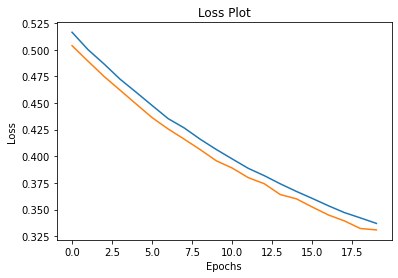

In [148]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

In [167]:
# The most lengthy caption has 35 chars
max_length = 35

### Greedy Search

In [190]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(resize_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [191]:
def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(resize_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption



In [192]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [193]:
from nltk.translate.bleu_score import sentence_bleu

In [194]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [195]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BELU score: 37.79644730092272
Real Caption: muzzled white dogs running
Prediction Caption: two white dogs running through the grass


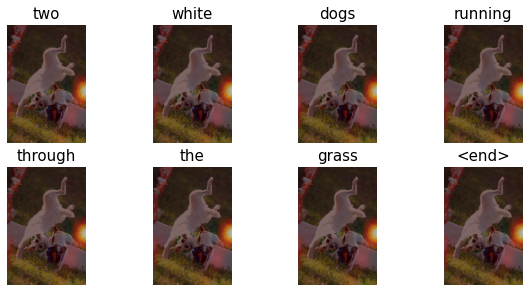

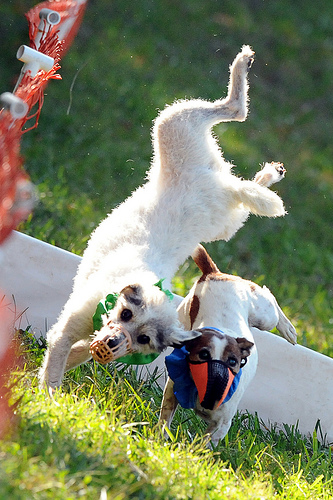

In [207]:
rid = np.random.randint(0, len(X_test))
test_image = X_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in y_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [208]:
captions=beam_evaluate(test_image)
print(captions)

two white dogs running through the grass


In [209]:
!pip install gTTS

In [212]:
from gtts import gTTS
from IPython.display import Audio
tts = gTTS("Image has: "+ pred_caption) 
tts.save('s.wav')
sound_file = 's.wav'
Audio(sound_file, autoplay=True)